# Conditional Workflow

- Create a conditional edge between two nodes.
- Behaves like a if-else.

In [1]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Annotated, Literal, Optional

from pydantic import BaseModel, Field

In [2]:
from langchain.chat_models import init_chat_model
from langchain.messages import HumanMessage, ToolMessage, AIMessage

model = init_chat_model(
    model="deepseek-r1:1.5b",
    model_provider="ollama",
    temperature = 0.0
)

## Quadratic Workflow

In [3]:
class QuadState(TypedDict):

    a: int
    b: int
    c: int

    equation: str
    discriminant: float
    result: str

In [4]:
def show_equation(state: QuadState):

    equation = f'{state["a"]}x2{state["b"]}x{state["c"]}'

    return {'equation':equation}

def calculate_discriminant(state: QuadState):

    discriminant = state["b"]**2 - (4*state["a"]*state["c"])

    return {'discriminant': discriminant}

def real_roots(state: QuadState):

    root1 = (-state["b"] + state["discriminant"]**0.5)/(2*state["a"])
    root2 = (-state["b"] - state["discriminant"]**0.5)/(2*state["a"])

    result = f'The roots are {root1} and {root2}'

    return {'result': result}

def repeated_roots(state: QuadState):

    root = (-state["b"])/(2*state["a"])

    result = f'Only repeating root is {root}'

    return {'result': result}

def no_real_roots(state: QuadState):

    result = f'No real roots'

    return {'result': result}

def check_condition(state: QuadState) -> Literal["real_roots", "repeated_roots", "no_real_roots"]:

    if state['discriminant'] > 0:
        return "real_roots"
    elif state['discriminant'] == 0:
        return "repeated_roots"
    else:
        return "no_real_roots"

In [5]:
graph = StateGraph(QuadState)

graph.add_node('show_equation', show_equation)
graph.add_node('calculate_discriminant', calculate_discriminant)
graph.add_node('real_roots', real_roots)
graph.add_node('repeated_roots', repeated_roots)
graph.add_node('no_real_roots', no_real_roots)


graph.add_edge(START, 'show_equation')
graph.add_edge('show_equation', 'calculate_discriminant')

graph.add_conditional_edges('calculate_discriminant', check_condition)
graph.add_edge('real_roots', END)
graph.add_edge('repeated_roots', END)
graph.add_edge('no_real_roots', END)

workflow = graph.compile()

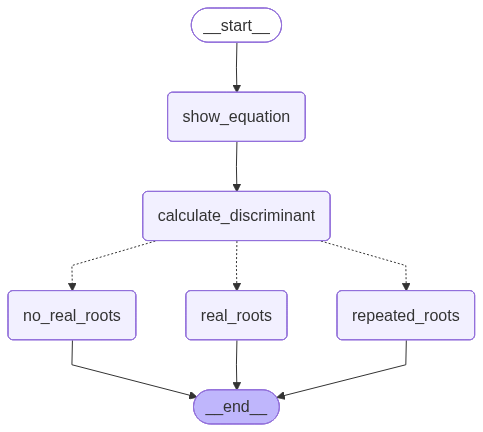

In [6]:
workflow

In [7]:
initial_state = {
    'a': 2, 
    'b': 4,
    'c': 2
}

workflow.invoke(initial_state)

{'a': 2,
 'b': 4,
 'c': 2,
 'equation': '2x24x2',
 'discriminant': 0,
 'result': 'Only repeating root is -1.0'}

## LLM Conditional Workflow

In [8]:
class SentimentSchema(BaseModel):

    sentiment: Literal["positive", "negative"] = Field(description='Sentiment of the review')

In [9]:
class DiagnosisSchema(BaseModel):
    issue_type: Literal["UX", "Performance", "Bug", "Support", "Other"] = Field(description='The category of issue mentioned in the review')
    tone: Literal["angry", "frustrated", "disappointed", "calm"] = Field(description='The emotional tone expressed by the user')
    urgency: Literal["low", "medium", "high"] = Field(description='How urgent or critical the issue appears to be')

In [10]:
structured_model = model.with_structured_output(SentimentSchema)
structured_model2 = model.with_structured_output(DiagnosisSchema)

In [11]:
prompt = 'What is the sentiment of the following review - The software too good'
structured_model.invoke(prompt).sentiment

'negative'

In [12]:
class ReviewState(TypedDict):

    review: str
    sentiment: Literal["positive", "negative"]
    diagnosis: dict
    response: str

In [13]:
def find_sentiment(state: ReviewState):

    prompt = f'For the following review find out the sentiment \n {state["review"]}'
    sentiment = structured_model.invoke(prompt).sentiment

    return {'sentiment': sentiment}

def check_sentiment(state: ReviewState) -> Literal["positive_response", "run_diagnosis"]:

    if state['sentiment'] == 'positive':
        return 'positive_response'
    else:
        return 'run_diagnosis'
    
def positive_response(state: ReviewState):

    prompt = f"""Write a warm thank-you message in response to this review:
    \n\n\"{state['review']}\"\n
Also, kindly ask the user to leave feedback on our website."""
    
    response = model.invoke(prompt).content

    return {'response': response}

def run_diagnosis(state: ReviewState):

    prompt = f"""Diagnose this negative review:\n\n{state['review']}\n"
    "Return issue_type, tone, and urgency.
"""
    response = structured_model2.invoke(prompt)

    return {'diagnosis': response.model_dump()}

def negative_response(state: ReviewState):

    diagnosis = state['diagnosis']

    prompt = f"""You are a support assistant.
The user had a '{diagnosis['issue_type']}' issue, sounded '{diagnosis['tone']}', and marked urgency as '{diagnosis['urgency']}'.
Write an empathetic, helpful resolution message.
"""
    response = model.invoke(prompt).content

    return {'response': response}

In [14]:
graph = StateGraph(ReviewState)

graph.add_node('find_sentiment', find_sentiment)
graph.add_node('positive_response', positive_response)
graph.add_node('run_diagnosis', run_diagnosis)
graph.add_node('negative_response', negative_response)

graph.add_edge(START, 'find_sentiment')

graph.add_conditional_edges('find_sentiment', check_sentiment)

graph.add_edge('positive_response', END)

graph.add_edge('run_diagnosis', 'negative_response')
graph.add_edge('negative_response', END)

workflow = graph.compile()

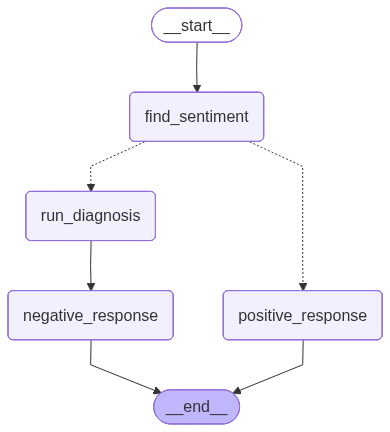

In [15]:
workflow

In [16]:
intial_state={
    'review': "I’ve been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality."
}
workflow.invoke(intial_state)

{'review': 'I’ve been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality.',
 'sentiment': 'negative',
 'diagnosis': {'issue_type': 'Bug', 'tone': 'frustrated', 'urgency': 'low'},
 'response': "I'm sorry you're feeling frustrated. Could you share more about what happened? If this is something you'd like to talk to a professional about, let me know how I can assist you."}